In [5]:
import matplotlib.pyplot as plt
%matplotlib widget 

import numpy as np
import mne
#mne.datasets.sample.data_path()

import torch
import eegCompressModels

from torch.utils.data import DataLoader, TensorDataset

In [6]:
#raw = mne.io.read_raw_fif('./mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif')
raw = mne.io.read_raw_edf('/teamspace/uploads/ExampleLTMFiles/SVD001.edf')

Extracting EDF parameters from /teamspace/uploads/ExampleLTMFiles/SVD001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_10423/3455569217.py:2: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf('/teamspace/uploads/ExampleLTMFiles/SVD001.edf')


In [7]:
print(raw)
print(raw.info)

<RawEDF | SVD001.edf, 46 x 1276416 (4986.0 s), ~48 KiB, data not loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F7, T7, P7, O1, F3, C3, P3, A1, Fz, Cz, Fp2, F8, T8, P8, ...
 chs: 46 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2001-01-01 04:46:55 UTC
 nchan: 46
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: SVD001>
>


In [8]:
chanList = range(0,19)
nChannel = len(chanList)

data = raw.get_data()[chanList] #eeg channels
data.shape

(19, 1276416)

In [9]:
numSampleInput = 50
outSample = 10

inSize = nChannel * numSampleInput
outSize = nChannel * outSample
print(inSize, outSize)

950 190


In [10]:
nBlock = data.size // inSize
resizeSamples = nBlock * numSampleInput

dataReshape = np.reshape(data[:, 0:resizeSamples], (inSize, -1), order='F').transpose()
dataReshape = dataReshape.astype('float32')
dataReshape.shape

(25528, 950)

In [11]:
dataset = TensorDataset(torch.from_numpy(dataReshape), torch.from_numpy(np.arange(0, dataReshape.shape[0])))
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
model = eegCompressModels.AE(inSize, outSize)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)

In [13]:
epochs = 20
outputs = []
losses = []
for epoch in range(epochs):
	for (image, _) in loader:
		
		# Output of Autoencoder
		reconstructed = model(image.to(torch.float32))
		
		# Calculating the loss function
		loss = loss_function(reconstructed, image)
		
		# The gradients are set to zero,
		# the gradient is computed and stored.
		# .step() performs parameter update
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Storing the losses in a list for plotting
		losses.append(loss)
		outputs.append((epochs, image, reconstructed))


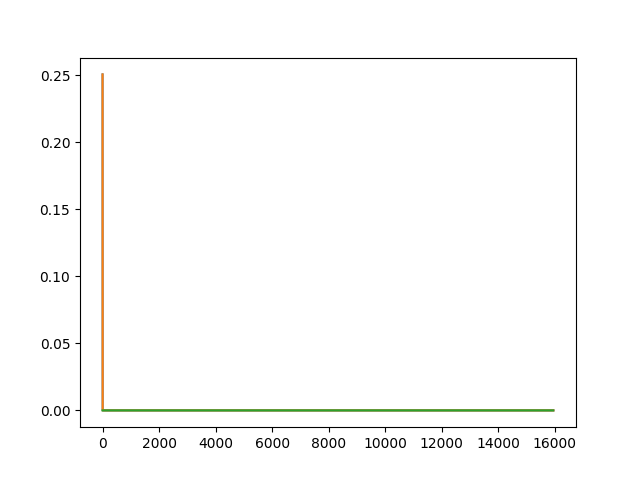

In [19]:
plt.plot([i.detach().numpy() for i in losses[10:]])
plt.show()

### Saving the model

In [31]:
torch.save(model.state_dict(), 'savedModel')
!ls -lh

total 1.1M
drwxr-xr-x 1 jettinger35 jettinger35 4.0K Jan  6 20:06 __pycache__
-rwxr--r-- 1 jettinger35 jettinger35 6.0K Jan  6 22:15 eegCompress.ipynb
-rwxr--r-- 1 jettinger35 jettinger35  845 Jan  3 00:32 eegCompressModels.py
drwxr-xr-x 1 jettinger35 jettinger35 4.0K Jan  6 20:06 mne_data
-rw-r--r-- 1 jettinger35 jettinger35 1.1M Jan  6 22:15 savedModel
